<a href="https://colab.research.google.com/github/CPukszta/BI-BE-CS-183-2023/blob/main/HW2/Problem5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bi/Be/Cs 183 2022-2023: Intro to Computational Biology
TAs: Meichen Fang, Tara Chari, Zitong (Jerry) Wang

**Submit your notebooks by sharing a clickable link with Viewer access. Link must be accessible from submitted assignment document.**

Make sure Runtime $\rightarrow$ Restart and run all works without error

**HW 2 Problem 5**

Here you will explore how to use a *spatial* RNA-seq dataset to perform (1) logistic regression to extract genes which are cell type markers and (2) spatial (auto)correlation analysis to recover spatially-variant gene relationships, which may or may not map to cell type markers. This will combine using gene-count matrices and gene-coordinate matrices, where 2D coordinates are given for the genes in the tissue.

##**Import data and install packages**

In [2]:
!pip3 install --quiet anndata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 KB 3.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt #Can use other plotting packages like seaborn
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression

import anndata #Package for reading in single-cell datasets
import os

import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()


In [4]:
# ! allows you to run commands in the command line, as you would in your normal terminal/command line interface

In [5]:
#Download count matrix of cell by gene counts
#Cells are 10x sequenced neurons from the mouse hypothalamus (Kim et al. 2019)

import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname



In [6]:
#metadata.csv
download_file('10.22002/D1.2063','.gz')

#counts.h5ad
download_file('10.22002/D1.2064','.gz')

os.system("gunzip *.gz")

os.system("mv D1.2063 metadata.csv")
os.system("mv D1.2064 counts.h5ad")

<ipython-input-5-1f0c3f82847e>:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  pbar = tnrange(int(total_length/1024), unit="B")


  0%|          | 0/9784 [00:00<?, ?B/s]

  0%|          | 0/59360 [00:00<?, ?B/s]

0

## **Read in data for analysis**

**The dataset**

This dataset is taken from [Zhang et al. 2021](https://www.nature.com/articles/s41586-021-03705-x#Sec8). The goal of this study was to look at the spatial mRNA profile of mouse primary motor cortex (MOp) using a single-cell transcriptome-imaging method i.e. multiplexed error-robust fluorescence in situ hybridization (MERFISH) [(see Moffitt et al. 2016)](https://www.pnas.org/doi/10.1073/pnas.1612826113). 

MERFISH uses combinatorial oligonucleotide labeling to barcode RNAs (e.g. on a slice of tissue), enabling transcriptome-scale RNA imaging of individual cells. Molecule detection and counting is done through sequential rounds of imaging and *in situ* hybridization of fluorescent probes to the mRNA molecules, using single-molecule FISH techniques (smFISH). 

From the imaging analysis, we have counts of genes per cell (cells determined by image segmentation) and physical coordinates for these cells.

<center><img src="https://drive.google.com/uc?export=view&id=130o7cb0HeqNXA39eV61M8UoUVkJYByAi" alt="MOpFigure" width="800" height="350"><center>



**The Count matrix**

The full matrix has ~280,000 cells by 254 genes. Though images were taken over three dimensions (x,y,z coordinates) we will use only one tissue slice (x,y coordinates at one z coordinate) for analysis, which has 6,963 cells.

1.   For each cell, gene counts were normalized to have the same number of total counts (usually 1e5 or 1e6), with cell-gene counts thus scaled accordingly.

2.   Counts were then log-normalized, using the log(1+x), where x is each cell's gene count. 

The metadata data contains coordinates, x and y, for each cell.


 


In [7]:
#Get gene count matrix

counts = anndata.read('./counts.h5ad')
counts.shape

     

(280327, 254)

In [8]:
#Get metadata dataframe for the 41,580 cells (rows of the matrix)
cellMeta = pd.read_csv('./metadata.csv')
cellMeta.head()
     

,Unnamed: 0,fovID,fov_x,fov_y,volume,center_x,center_y,slice_id,sample_id,label,subclass,class_label
0,1.000010e+37,13,4539.310,2986.899,992.830060,4738.397298,3075.327399,mouse2_slice31,dataset2_sample4,Astro_1,Astrocytes,Other
1,1.000020e+38,290,-4016.860,1404.780,610.091871,-3964.711404,1451.889047,mouse2_slice160,dataset2_sample5,Endo,Endothelial,Other
2,1.000070e+38,113,750.406,1143.102,148.277718,805.843523,1215.035473,mouse2_slice109,dataset2_sample6,SMC,SMC,Other
3,1.000070e+38,432,1262.680,-3752.030,249.515471,1348.686198,-3589.955255,mouse1_slice71,dataset1_sample2,Endo,Endothelial,Other
4,1.000090e+38,354,-3627.450,-1987.730,1779.831996,-3584.650904,-1883.105955,mouse2_slice219,dataset2_sample5,L23_IT_3,L23_IT,Glutamatergic


In [9]:
#Subset for only a single slice of the tissue (z-stack)
choice = np.unique(cellMeta.slice_id)[7] #7
choice


'mouse1_slice162'

In [10]:
#Subset the anndata object
counts.obs['slice'] = pd.Categorical(cellMeta.slice_id)

sub = counts[counts.obs['slice'].isin([choice])]
print(sub)


cellMeta_sub = cellMeta[cellMeta['slice_id'].isin([choice])]
meta = pd.DataFrame()
meta['type'] = cellMeta_sub['subclass']
meta['x'] = cellMeta_sub['center_x']#Use center of cell coordinates
meta['y'] = cellMeta_sub['center_y']

gene_names = np.array(sub.var_names)

meta


View of AnnData object with n_obs × n_vars = 6963 × 254
    obs: 'slice'


,type,x,y
19,Microglia,-5708.654099,-1647.945955
28,L6_IT,-6813.115601,-2076.176954
86,Astrocytes,-6236.278100,-2378.800452
138,Oligodendrocytes,-5864.400100,-2630.015455
163,L23_IT,-4336.870103,-2641.078955
...,...,...,...
280020,L6_IT_Car3,-5165.864102,-2960.215952
280078,Astrocytes,-6780.633602,-1305.225453
280113,L23_IT,-6686.363599,-1091.872954
280203,L45_IT,-5238.730600,-1744.737953


Make count matrix and metadata to be used in Problem 5

In [11]:
count_mat = np.log1p(sub.X)
print(count_mat.shape)

#Show metadata
meta.head()

(6963, 254)


,type,x,y
19,Microglia,-5708.654099,-1647.945955
28,L6_IT,-6813.115601,-2076.176954
86,Astrocytes,-6236.278100,-2378.800452
138,Oligodendrocytes,-5864.400100,-2630.015455
163,L23_IT,-4336.870103,-2641.078955


In [12]:
#See all the cell type categories
np.unique(meta['type']) #Cell populations are marked by the genes they express (as compared to other cell populations)

array(['Astrocytes', 'Endothelial', 'L23_IT', 'L45_IT', 'L56_NP', 'L5_IT',
       'L5_PT', 'L6_CT', 'L6_IT', 'L6_IT_Car3', 'L6b', 'Lamp5',
       'Microglia', 'OPC', 'Oligodendrocytes', 'PVM', 'Pericytes',
       'Pvalb', 'SMC', 'Sncg', 'Sst', 'Sst_Chodl', 'VLMC', 'Vip', 'other'],
      dtype=object)

In [13]:
#First 10 genes names, in the cell x gene matrix
gene_names[0:10]

array(['1700022I11Rik', '1810046K07Rik', '5031425F14Rik', '5730522E02Rik',
       'Acta2', 'Adam2', 'Adamts2', 'Adamts4', 'Adra1b', 'Alk'],
      dtype=object)

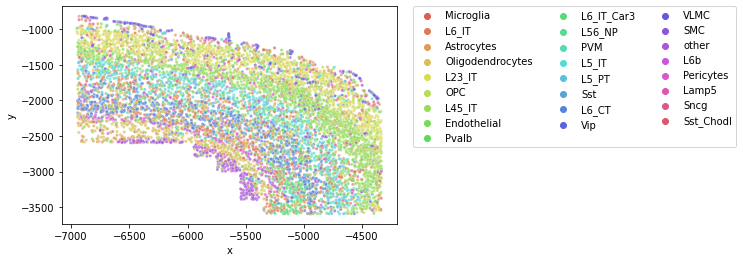

In [14]:
#See how the cell types appear on 2D coordinates

sns.scatterplot(x=meta['x'],y=meta['y'],hue=meta['type'],s=10,alpha=0.7,palette='hls') #Using seaborn (sns) for plotting
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,ncol=3)

## **Problem 5 (28 points)**
Here we will explore how to use (1) logistic regression to extract cell type markers and (2) calculate Moran's *I* to determine clusters of genes with spatially correlated expression. 

You will use the **count_mat** above for the cellxgene matrix, and the **meta** above as the metadata for the cells, which has cell type ('type') and x/y coordinates ('x' and 'y').

***Logistic Regression***

How to use logistic regression functions from sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 


```
>>> from sklearn.datasets import load_iris
>>> from sklearn.linear_model import LogisticRegression
>>> X, y = load_iris(return_X_y=True)
>>> clf = LogisticRegression(random_state=0).fit(X, y)
# .coef_ and .intercept_ the same as LinearRegression
```



### **a) Set up logistic regression model for cell type classification of Astrocyte cells and report marker genes with largest coefficients ( 9 points)** 

With logistic regression we can model a categorical variable (e.g. cell type) as a continuous value (i.e. the probability of being in the category). Here we will model the contribution of each gene to the probability of a cell being in the Astrocyte cell type or not. 

We will define y as a binary value, 1 or 0, representing whether a cell is in the Astrocyte cell type or not, respectively.

The full model is $$log(\dfrac{p}{1-p}) = \alpha + \beta X$$

*p* represents the probability of being in the cell type or not (i.e. probability y=1). X is the count_mat (samples x features or cells x genes)




Astrocytes represent a subset of glial cells (non-neuronal cells in the central nervous system, CNS) that do not produce electrical impulses, and often appear as star-shaped. They have many roles in maintaining homeostasis and neuronal metabolism across the CNS. This can include mechanical support of neurons as well as controlling release of nutrients/metabolites. 


**Fit separate, logistic regression models for each of the 254 genes, and report the top 10 genes with the highest beta coefficients i.e. the genes where changes in their expression highly contribute to the probability of the cell being in the desired category, or Astrocyte 'marker genes'.** 

We take 'highest' to mean largest, positive coefficient


In [25]:
#Set up model and extract beta
cell_type =meta["type"].tolist()
y = np.zeros(len(cell_type))
for i in range(len(cell_type)):
  if cell_type[i]=='Astrocytes':
    y[i] = 1
  else:
    y[i] = 0

betas = np.zeros(len(count_mat))
for i in range(len(count_mat[0,:])):
  X=count_mat[:,i].reshape((-1,1))
  clf =LogisticRegression(random_state=0)
  clf.fit(X, y)
  betas[i] = clf.coef_

#Determine top ten genes which identify the Astrocytes (Rank the model coefficients)
ind = np.argpartition(betas, -10)[-10:]
ind = ind[np.argsort(betas[ind])]

print("the top 10 genes, from smallest to largest beta coefficents are:", gene_names[ind].tolist())
print("beta Coefficents:", betas[ind])

the top 10 genes, from smallest to largest beta coefficents are: ['Pdlim5', 'Pou3f3', 'Daam2', 'Bmpr1b', 'Luzp2', 'Egfr', 'Lama3', 'Aqp4', 'Cxcl14', 'Frem2']
beta Coefficents: [1.50225588 1.70782272 1.7486766  1.92454968 1.97298488 2.0658843
 2.16069581 2.18179687 2.30066458 2.33152065]


### **b) Calculate the Moran's *I* measure for spatial-autocorrelation. We will be using local Moran's *I* as this will give us correlation values for each cell, as opposed to one value for the whole plane. Equation given below. ( 7 points)** 

$$I^g_{i}={\frac {x_{i}-{\bar {x}}}{\frac {\sum _{k=1}^{N}(x_{k}-{\bar {x}})^{2}}{N}}}\sum _{j=1}^{N}w_{ij}(x_{j}-{\bar {x}})$$


For each cell $i$, calculate its $I^g_{i}$ where $x_i$ is the cell's expression for one gene $g$ and $\bar {x}$ is the average expression for that gene $g$, across all cells. $N$ is number of cells. $w_{i,j}$ represents the weight between cells $i$ and $j$. Thus you will need to create a pairwise distance matrix $w$ which calculates the (Euclidean) distances between all cells using their x and y coordinates.

Positive values of Moran's *I* denote greater spatial autocorrelation/clustering. More negative values indicate greater dispersion.

**Calculate the local Moran's *I* ($I^g_i$) for each cell and each gene. (This is for all 254 genes)**

**Print the $I^g_i$ values for the first 10 cells and the first 10 genes.** 

You can use sklearn pairwise_distances https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html

In [26]:
#start by computing the distance matrix w
x = meta[["x","y"]].values
w = sklearn.metrics.pairwise_distances(x)

# compute the moran's I measure
I = np.zeros(count_mat.shape)
N = 6963
for i in range(6963):
  for j in range(254):
    x_i = count_mat[i,j]
    x_bar = np.average(count_mat[:,j])
    num = x_i - x_bar
    denom = np.sum((count_mat[:,j]-x_bar)**2)/N
    dis = np.sum(w[i,:]*(count_mat[:,j]-x_bar))
    I[i,j] = (num/denom)*dis

Now lets print the $I^g_i$ values for the first 10 cells and the first 10 genes.



In [27]:
I_df = pd.DataFrame(I)

print("these are the local Moran's I for the first 10 cells and first 10 genes:")
I_df.iloc[0:10,:10]

these are the local Moran's I for the first 10 cells and first 10 genes:


,0,1,2,3,4,5,6,7,8,9
0,6855.062709,6259.015447,8730.925403,8077.092984,-33540.195917,183581.182872,-19721.747276,-1.803987e+04,1.967198e+05,5879.127033
1,-9775.281889,103550.321113,15945.469579,133177.643887,-13835.396489,197015.541425,78727.700787,-5.343908e+03,-1.751081e+06,-11035.740413
2,-7760.322780,-33810.988428,11952.983875,-14330.157694,9062.573720,-19877.688234,63773.259833,4.304646e+05,3.413181e+05,-18457.170380
3,78872.570500,-37734.460662,8362.908923,-6715.754439,1969.092509,5116.649810,-169739.670619,-1.709942e+06,1.501183e+05,-20447.854763
4,13122.720590,15580.536402,273412.059776,23248.976497,76569.111925,45642.274956,-93843.928423,-1.702846e+05,-3.869425e+05,-2566.722263
5,6647.178000,-4710.978355,-746.831858,17371.966818,49988.565146,37840.422992,-46267.950066,3.017157e+04,-1.780364e+05,-11079.268931
6,13216.781440,22381.635636,-5265.941655,31073.973119,85158.512606,29216.059112,-89504.989298,-2.358442e+05,-4.191643e+05,-3680.596254
7,10952.180964,7774.921384,-6679.771274,21786.752748,-24344.351668,42181.703242,-80061.505546,-1.041108e+05,-3.209593e+05,-6844.496904
8,11236.475218,-38619.788394,-6234.645981,23168.755187,69006.570140,40584.488259,-81756.205385,-1.156047e+05,-3.329583e+05,-7678.109661
9,4754.696458,11847.783023,6689.459668,-166045.413639,7969.523469,-27226.064692,-16182.603448,-9.889634e+04,1.689796e+05,7025.608254


### **c) Find the top 3 genes with the highest average autocorrelation values (across the cells). ( 6 points)**

**Make 3 plots (one for each gene) which plot the x,y coordinates of the cells, and color the cells by their corresponding $I^g_i$ values for each of the 3 genes. Print the names of the genes as well.** 

See the 'Read in Data' section for example plot functions.


In [35]:
# lets start by averaging across all the cells and then determining the genes with the highest values
I_avg = np.average(I,axis=0)
inds = sorted(range(len(I_avg)),reverse=True,key=lambda i: I_avg[i])[:3]

print("the top 3 genes, from smallest to largest average I values are:", gene_names[inds].tolist())

the top 3 genes, from smallest to largest average I values are: ['Cdcp1', 'Muc20', 'Mrgprx2']


In [40]:
from bokeh.models import ColorBar, ColumnDataSource
from bokeh.palettes import Turbo256
from bokeh.plotting import figure, output_file, show
from bokeh.transform import linear_cmap

plot_lists = []
for i in inds[0:3]:
  mapper = linear_cmap(field_name='I', palette=Turbo256 ,low=min(I[:,i]) ,high=max(I[:,i]))

  source = ColumnDataSource(dict(x=x[:,0],y=x[:,1],I=I[:,i]))

  g = bokeh.plotting.figure(
    height=500,
    width=500,
    title = "cell cooridinates colored by I values for gene: "+gene_names[i],
    x_axis_label = "x",
    y_axis_label = "y"
  )

  g.circle(x="x",y='y',color=mapper,source=source, size=1.6,alpha=1)

  color_bar = ColorBar(color_mapper=mapper['transform'], width=8)
  g.add_layout(color_bar, 'right')
  plot_lists.append(g)

bokeh.io.show(plot_lists[0])
bokeh.io.show(plot_lists[1])
bokeh.io.show(plot_lists[2])

### **d) Choose 3 of marker genes from part a) and make the same plots as c for them, to see the markers' autocorrelation patterns. ( 6 points)**

In [23]:
plot_list = []
for i in ind[0:3]:
  mapper = linear_cmap(field_name='I', palette=Turbo256 ,low=min(I[:,i]) ,high=max(I[:,i]))

  source = ColumnDataSource(dict(x=x[:,0],y=x[:,1],I=I[:,i]))

  g = bokeh.plotting.figure(
    height=500,
    width=500,
    title = "cell cooridinates colored by I values for gene: "+gene_names[i],
    x_axis_label = "x",
    y_axis_label = "y"
  )

  g.circle(x="x",y='y',color=mapper,source=source, size=1.8)

  color_bar = ColorBar(color_mapper=mapper['transform'], width=8)
  g.add_layout(color_bar, 'right')
  plot_list.append(g)

# grid = bokeh.plotting.gridplot(plot_list, plot_width=250, plot_height=250)
bokeh.io.show(plot_list[0])
bokeh.io.show(plot_list[1])
bokeh.io.show(plot_list[2])